# Algoritimos e benchmarks com `BenchmarkTools.jl`

In [3]:
using BenchmarkPlots
using BenchmarkTools
using LaTeXStrings
using Plots
using Random: seed!
using StatsPlots
using Pkg

In [6]:
const rng = seed!(123)

MersenneTwister(123)

In [7]:
X = rand(3, 3)

3×3 Matrix{Float64}:
 0.768448  0.395453  0.586022
 0.940515  0.313244  0.0521332
 0.673959  0.662555  0.26864

In [8]:
@time inv(X)

  0.228785 seconds (511.54 k allocations: 29.306 MiB, 99.94% compilation time)


3×3 Matrix{Float64}:
  0.256297   1.45711   -0.841869
 -1.12381   -0.973961   2.64054
  2.1287    -1.25346   -0.677921

In [9]:
@time inv(X)

  0.000019 seconds (4 allocations: 1.953 KiB)


3×3 Matrix{Float64}:
  0.256297   1.45711   -0.841869
 -1.12381   -0.973961   2.64054
  2.1287    -1.25346   -0.677921

> notar que o tempo da segunda é muito mais rápida e não teve tempo gasto com compilação!

# `BenchmarkTools.jl`

In [10]:
# LLVM vai JIT compile da segunda vez em diante e otimizar
@benchmark sin.(X)

BenchmarkTools.Trial: 10000 samples with 188 evaluations.
 Range (min … max):  539.362 ns …  26.811 μs  ┊ GC (min … max): 0.00% … 96.58%
 Time  (median):     547.872 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   695.015 ns ± 565.133 ns  ┊ GC (mean ± σ):  1.13% ±  2.46%

  █▃▅▅▂▁▂▁▁▁▁▁▁▁▁▁▁▂                                            ▁
  ███████████████████████▇▇▇▆▇▇▇▆▆▅▆▅▆▆▅▅▅▅▅▆▅▆▅▄▅▅▄▄▄▅▄▁▁▁▁▃▄▄ █
  539 ns        Histogram: log(frequency) by time       2.55 μs <

 Memory estimate: 192 bytes, allocs estimate: 3.

In [13]:
# Usando o '$' o LLVM não consegue inferir o X, então nós temos JIT mas não há otimização
@benchmark sin.($X)

BenchmarkTools.Trial: 10000 samples with 964 evaluations.
 Range (min … max):   83.610 ns …   5.505 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):      87.344 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   125.424 ns ± 167.592 ns  ┊ GC (mean ± σ):  3.55% ± 5.06%

  █▄▅▃▂▂▂▂▃▃▂▁▁▁▁                                               ▁
  ███████████████████▇▇▇▇▇▆▅▇▆▆▅▅▅▅▅▅▄▃▄▃▃▄▄▅▄▄▃▃▃▃▂▂▃▅▂▂▂▄▃▂▂▄ █
  83.6 ns       Histogram: log(frequency) by time        553 ns <

 Memory estimate: 160 bytes, allocs estimate: 1.

In [12]:
# forma mais simples de usar o BenchmarkTools
@btime cos.(X)

  484.615 ns (3 allocations: 192 bytes)


3×3 Matrix{Float64}:
 0.71899   0.922822  0.833147
 0.589372  0.951339  0.998641
 0.781357  0.788423  0.964133

## `BenchmarkTools.Trial`

macro `@simd` -> Single Instructions Multiple Data (arquitetura criada pela Intel) para paralelização

In [27]:
function sumsimd(a)
    result = zero(eltype(a))
    @simd for x in a 
        result += x 
    end
    return result
end

sumsimd (generic function with 1 method)

In [28]:
vec_a = randn(42_000);

In [29]:
bench_obj = @benchmark sumsimd($vec_a)

BenchmarkTools.Trial: 10000 samples with 7 evaluations.
 Range (min … max):  4.843 μs … 319.543 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     4.900 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   6.166 μs ±   7.907 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █▄▄▄▄▂▂▂▁                                                   ▁
  ██████████████▇█▇▆▆▇▆▆▅▆▅▅▅▄▆▄▅▄▅▆▄▅▅▅▃▅▅▄▄▅▄▅▁▄▄▅▅▅▅▄▅▄▄▅▅ █
  4.84 μs      Histogram: log(frequency) by time      25.9 μs <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [30]:
typeof(bench_obj)

BenchmarkTools.Trial

In [31]:
first.(split.(string.(methodswith(BenchmarkTools.Trial)), "("))

27-element Vector{SubString{String}}:
 "allocs"
 "gctime"
 "mean"
 "median"
 "memory"
 "params"
 "rmskew"
 "rmskew!"
 "trim"
 "trim"
 "getindex"
 "getindex"
 "sort"
 ⋮
 "copy"
 "deleteat!"
 "lastindex"
 "length"
 "maximum"
 "minimum"
 "push!"
 "show"
 "show"
 "sort!"
 "summary"
 "time"

In [32]:
# média de tempo gasto para fazer essa operação
summary(bench_obj)

"Trial(4.843 μs)"

In [33]:
# não tem nenhuma alocação (isso o torna muito eficiente) por causa do @simd
allocs(bench_obj)

0

In [34]:
# garbage collector
gctime(bench_obj)

0.0

## Visualizar os benchmarks

In [35]:
using BenchmarkPlots
using StatsPlots

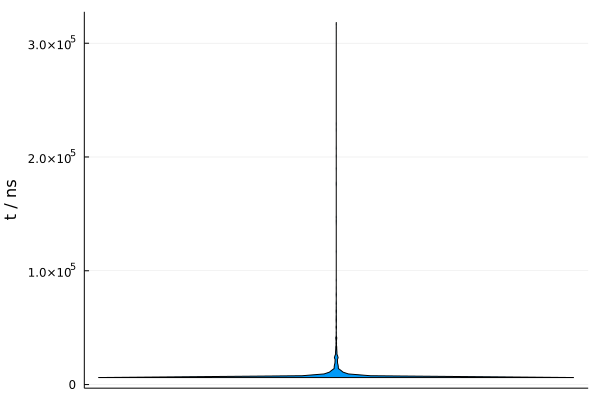

In [36]:
plot(bench_obj)